In [1]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import joblib 

# graphing
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# function to download the compressed data set (.tgz) from the given url
# then unpack the .csv
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# once we've downloaded and unpacked the data using the above fn, use
# pandas to read in the .csv as a pandas DataFrame
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
# download the data set
fetch_housing_data()

In [3]:
# load the data set into a pandas DataFrame
HousingData = load_housing_data()

# Initial Exploration  
What attributes do we have? What do their distributions look like overall? Are there any anomalies we should look out for later?

In [4]:
# What does the data look like?
# show top 5 rows
HousingData.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# information on the amount of data (and null values)
HousingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# summary statistical information
HousingData.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029AA5A751D0>,
      dtype=object)

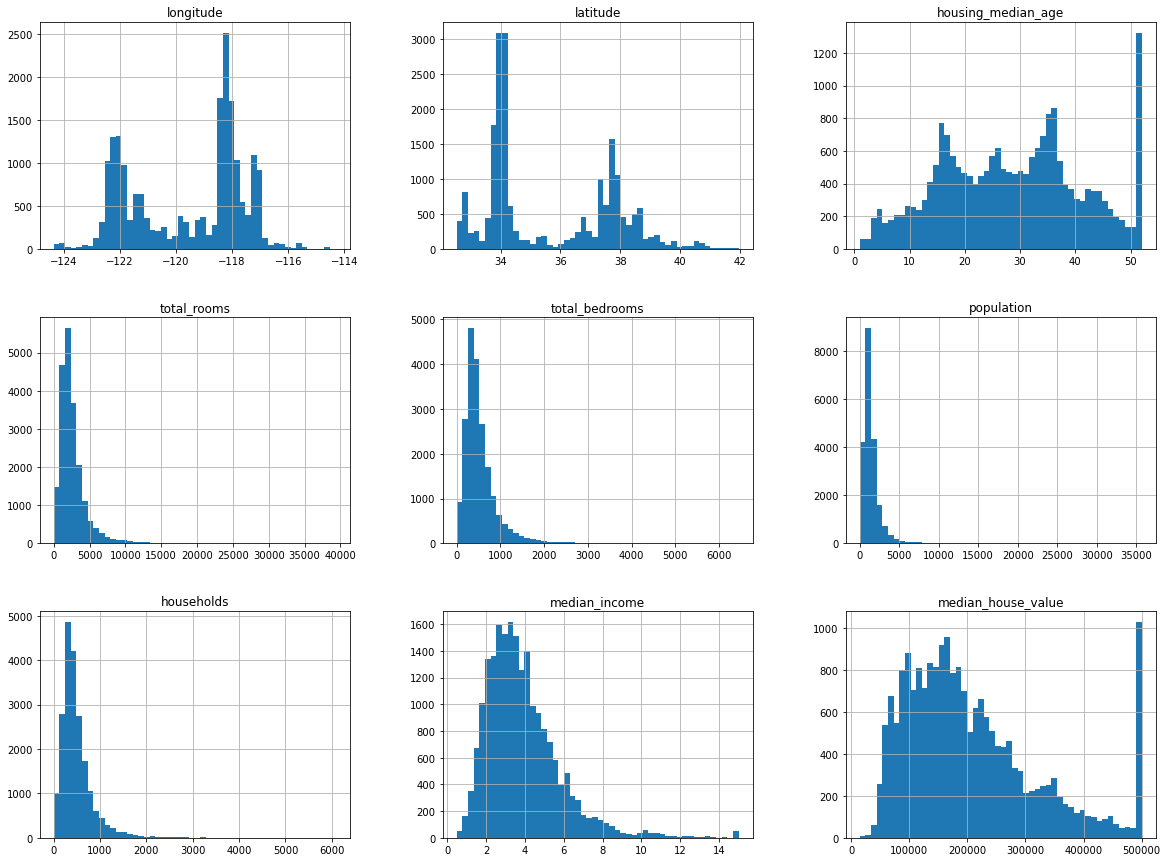

In [7]:
# For a graphical view of these columns, display histograms
HousingData.hist(bins=50,figsize=(20,15))

Observations of above numerical attributes:  
- Median income is scaled roughly in units of \$10,000
- median income is capped between 0.5 and 15
- house values and ages are also capped at a maximum value

In [8]:
# the data contains one categorical variable: ocean_proximity
# show the value counts for this column
HousingData["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

# Train-Test Split
We will use 20% of the data for the training set, and set aside 80% for validation  
We predict median income to be an important feature, however the distribution has a long positive tail. For this reason, we will use a stratified train-test split based on median income. This should ensure that our training set is representative of the whole distribution of median incomes.

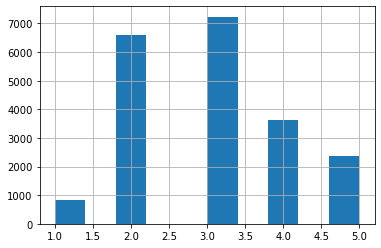

In [9]:
# create strata by adding category to the data
HousingData["income_cat"] = pd.cut(HousingData["median_income"],
                                  bins=[0,1.5,3.0,4.5,6,np.inf],
                                  labels=[1,2,3,4,5])

HousingData["income_cat"].hist()

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(HousingData, HousingData["income_cat"]):
    strat_train_set = HousingData.loc[train_index]
    strat_test_set = HousingData.loc[test_index]
    
# now that the data is split, we can remove the income category
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [11]:
# save our training and validation sets
joblib.dump(strat_train_set,"StratifiedTrainingSet.pkl")
joblib.dump(strat_test_set,"StratifiedTestSet.pkl")

['StratifiedTestSet.pkl']

# Discover and Visualize the Data

In [12]:
# We will work with purely the training set to avoid data snooping bias
housing = strat_train_set.copy()

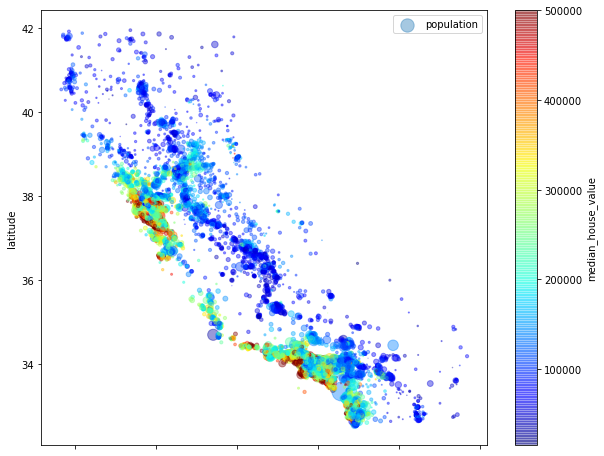

In [13]:
# geographical data
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
            s=housing["population"]/100,label="population",figsize=(10,8),
            c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

In [14]:
# looking for correlations between attributes and median housing price
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F00966A588>,
      dtype=object)

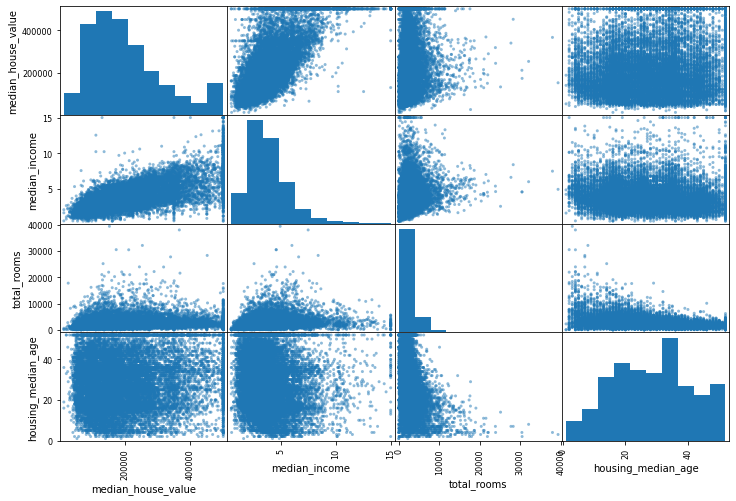

In [15]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

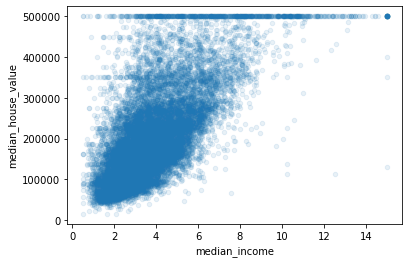

In [16]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

# Creating New Attributes  
Some of our attributes clearly have little relation to the target (e.g. why would total number of rooms in a district contribute to home values?). We will attempt to combine some attributes to make them relevant to the problem.

In [24]:
# rooms per household
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
# bedrooms per room
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
# population per household
housing["population_per_household"] = housing["population"]/housing["households"]

# check correlation matrix
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [ ]:
# save our training data
housing.